In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
# 检验状态 S 下能否采取动作 a
def check_action(width, height, S, a):
    S_ = (S[0]+a[0], S[1]+a[1])
    if S_[0] < 0 or S_[0] > height-1 or S_[1] < 0 or S_[1] > width-1:
        return False
    return True


# 计算状态 S 下采取动作 a 后的状态 S'
def move(width, height, S, a, wind, rand_move=False):
    x, y = S[0]+a[0], S[1]+a[1]
    x = max(x-wind[S[1]], 0)
    if rand_move:
        r = random.randint(1, 3)
        if r == 1:
            x = max(x-1, 0)
        elif r == 2:
            x = min(x+1, height-1)
    return (x, y)


# epsilon-贪心策略
def eps_greedy(width, height, S, action_all, eps, Q):
    actions = [a for a in action_all if check_action(width, height, S, a)]
    p = [eps/len(actions) for a in actions]
    q = [Q[S, a] for a in actions]
    p[q.index(max(q))] += 1-eps
    sum_p = 0
    random_value = random.random()
    for a, i in zip(actions, p):
        sum_p += i
        if sum_p >= random_value:
            return a


# Sarsa 算法
def Sarsa(alpha, gamma, eps, width, height, wind, action_all, G, S_start, iterations, rand_move=False):
    Q = {}
    for i in range(height):
        for j in range(width):
            actions = [a for a in action_all if check_action(
                width, height, (i, j), a)]
            for a in actions:
                if (i, j) == G:
                    Q[(i, j), a] = 0
                else:
                    Q[(i, j), a] = random.random()
    step_list = [0]
    for it in range(iterations):
        S = S_start
        step = 0
        while True:
            if step == 0:
                A = eps_greedy(width, height, S, action_all, eps, Q)
            S_ = move(width, height, S, A, wind, rand_move)
            R = -1
            A_ = eps_greedy(width, height, S_, action_all, eps, Q)
            Q[(S, A)] = Q[(S, A)]+alpha*(R+gamma*Q[(S_, A_)]-Q[(S, A)])
            S, A = S_, A_
            step += 1
            if S == G:
                break
        step_list.append(step_list[-1]+step)
    return step_list

## 练习6.9

> *在有风的网格世界中向 $8$ 个方向移动（编程）* 重新解决有风的网格世界问题。这次假设可以向包括对角线在内的 $8$ 个方向移动，而不是原来的 $4$ 个方向。利用更多的动作，你得到的结果比原来能好多少？如果还有第 $9$ 个动作，即除了风造成的移动之外不做任何移动，你能进一步获得更好的结果吗？

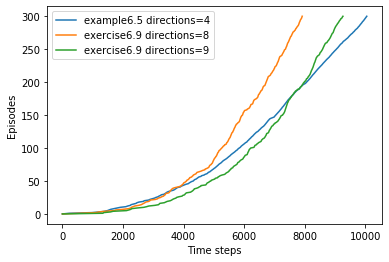

In [3]:
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
G = (3, 7)
S_start = (3, 0)
iterations = 300

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="example6.5 directions=4")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.9 directions=8")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.9 directions=9")

plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.legend()

图中蓝色线为例6.5的结果，橙色线为练习6.9中向 $8$ 个方向移动的结果，绿色线为练习6.9中向 $9$ 个方向移动的结果。图中曲线越陡，说明对应的模型能找到更优的路径。可以看到：
1. 与原来 $4$ 方向移动相比，增加移动方向后，由于可行的决策变多，选择决策的难度增加，在训练初期，$8$ 方向移动与 $9$ 方向移动的效果不如 $4$ 方向移动的效果。
2. 增加方向后灵活性增强，因此在训练后期，$8$ 方向移动与 $9$ 方向移动的效果明显优于 $4$ 方向移动的效果。
3. $8$ 方向移动与 $9$ 方向移动相比，后者仅仅增加了“原地不动”这一决策，但采取这一决策这并不会缩短到目标点的距离，反而会干扰决策，其效果不如 $8$ 方向移动。

## 练习6.10

> *随机强度的风（编程）* 重新解决在有风的网格世界中向 $8$ 个方向移动的问题。假设有风且风的强度是随机的，即在每列的平均值上下可以有 $1$ 的变化。也就是说，有三分之一的时间你在和之前问题中一样，精确地按照每列下标给出的数值移动，但另有三分之一的时间你会朝上多移动一格，还有三分之一的时间你会朝下多移动一格。举个例子，如果你在目标状态右边一格，你向左移动，那么在三分之一的时间你会移动到目标上方的一格，在另一个三分之一的时间你会移动到目标上方的两格，在剩下的三分之一的时间你会正好移动到目标。

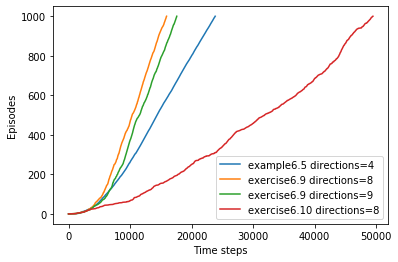

In [4]:
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
G = (3, 7)
S_start = (3, 0)
iterations = 1000

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="example6.5 directions=4")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.9 directions=8")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.9 directions=9")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
step_list = Sarsa(0.5, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations, rand_move=True)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.10 directions=8")

plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.legend()

与练习6.9相比，本题中，我们增加了红色线，即添加随机强度的风，并增加了幕数以观察模型收敛后的效果。

可以看到，当风的强度出现随机因素后，游戏难度提高，模型需要更多次迭代才能找到最优路径。但红色线的斜率居然比蓝色线更小，这是难以解释的，我们使用更小的 $\alpha$ 与更大的迭代次数进行测试。

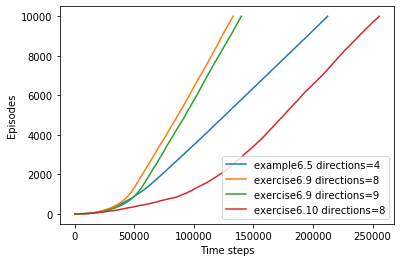

In [5]:
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
G = (3, 7)
S_start = (3, 0)
iterations = 10000

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0)]
step_list = Sarsa(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="example6.5 directions=4")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
step_list = Sarsa(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.9 directions=8")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]
step_list = Sarsa(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.9 directions=9")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
step_list = Sarsa(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations, rand_move=True)
plt.plot(step_list, list(range(iterations+1)), label="exercise6.10 directions=8")

plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.legend()

上图是 $\alpha=0.05$ 的结果，各模型的收敛速度变慢，但精度提高了，红色线的斜率与蓝色线相似，说明在前面的实验中，$\alpha$ 过大导致了震荡。

## 练习6.9与练习6.10拓展

我们不妨用热力图绘制出算法计算出的最优解 $\arg\max_a Q(S,a)$

注意，我们在每幕中随机初始化了起点 $S$，并减小了 $\alpha$，增加了迭代次数，以确保收敛。

Text(0.5, 1.0, 'exercise6.10 directions=8')

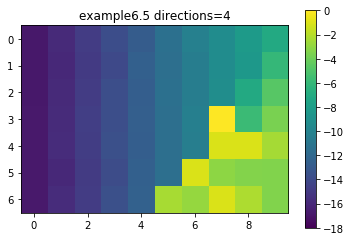

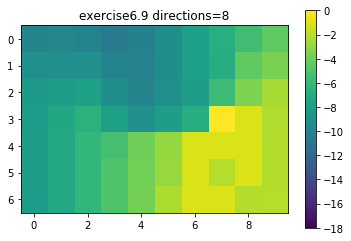

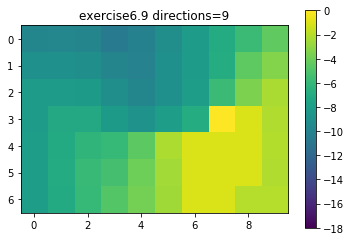

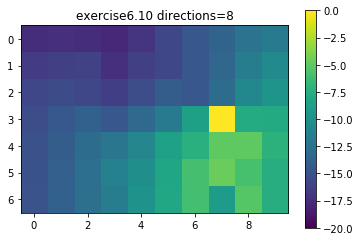

In [9]:
# Sarsa 算法 输出 argmax_a Q(S,a)
def Sarsa_Qm(alpha, gamma, eps, width, height, wind, action_all, G, S_start, iterations, rand_move=False):
    Q = {}
    for i in range(height):
        for j in range(width):
            actions = [a for a in action_all if check_action(
                width, height, (i, j), a)]
            for a in actions:
                if (i, j) == G:
                    Q[(i, j), a] = 0
                else:
                    Q[(i, j), a] = random.random()
    step_list = [0]
    for it in range(iterations):
        S = (random.randint(0, height-1), random.randint(0, width-1))
        step = 0
        while True:
            if S == G:
                break
            if step == 0:
                A = eps_greedy(width, height, S, action_all, eps, Q)
            S_ = move(width, height, S, A, wind, rand_move)
            R = -1
            A_ = eps_greedy(width, height, S_, action_all, eps, Q)
            Q[(S, A)] = Q[(S, A)]+alpha*(R+gamma*Q[(S_, A_)]-Q[(S, A)])
            S, A = S_, A_
            step += 1
        step_list.append(step_list[-1]+step)
    Qm = []
    for i in range(height):
        Qm.append([])
        for j in range(width):
            actions = [a for a in action_all if check_action(
                width, height, (i, j), a)]
            Qm[-1].append(max([Q[(i, j), a] for a in actions]))
    return Qm


wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
G = (3, 7)
S_start = (3, 0)
iterations = 20000

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0)]
Qm = Sarsa_Qm(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.figure()
plt.imshow(Qm, vmin = -18, vmax = 0)
plt.colorbar()
plt.title("example6.5 directions=4")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
Qm = Sarsa_Qm(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.figure()
plt.imshow(Qm, vmin = -18, vmax = 0)
plt.colorbar()
plt.title("exercise6.9 directions=8")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]
Qm = Sarsa_Qm(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations)
plt.figure()
plt.imshow(Qm, vmin = -18, vmax = 0)
plt.colorbar()
plt.title("exercise6.9 directions=9")

action_all = [(0, 1), (0, -1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
Qm = Sarsa_Qm(0.05, 1, 0.1, 10, 7, wind, action_all, G, S_start, iterations, rand_move=True)
plt.figure()
plt.imshow(Qm, vmin = -20, vmax = 0)
plt.colorbar()
plt.title("exercise6.10 directions=8")

图中点的颜色越黄，说明该点到目标点所需的步数越少。

第一张图是例6.5的结果，上风向处到达目标所需的步数更少，这是符合直觉的结论。

第二、三张图是练习6.9的结果，二者几乎完全相同，说明原地不动是一个并没有什么用的操作。

第四张图是练习6.10的结果，有趣的是，即使离目标点只有一步之遥，平均意义下仍需要多步才能到达，这归功于随机的风。